# Forecast of Manchester United Stock Price

In this notebook, we will use the stock prices of Manchester United Football Club over the previous five years to build a time-series model that will predict the future stock price.  

## Overview of Data

The data was downloaded from Yahoo Finance taking the daily stock price data for Manchester United Football Club over the previous five years.

## Cleaning the Data

First we import the necessary libraries and look at the top and bottom five rows of the data:

In [44]:
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout

In [3]:
df = pd.read_csv('MANU.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-10-20,16.049999,16.049999,15.830000,15.900000,15.093544,15300
1,2016-10-21,15.900000,15.950000,15.600000,15.900000,15.093544,22400
2,2016-10-24,15.750000,15.900000,15.600000,15.800000,14.998615,35600
3,2016-10-25,15.800000,15.800000,15.500000,15.500000,14.713833,23400
4,2016-10-26,15.500000,15.550000,15.350000,15.450000,14.666368,11200
...,...,...,...,...,...,...,...
1253,2021-10-13,16.610001,16.670000,16.309999,16.450001,16.450001,459300
1254,2021-10-14,16.590000,16.650000,16.340000,16.510000,16.510000,222000
1255,2021-10-15,16.469999,16.639999,16.430000,16.610001,16.610001,358700
1256,2021-10-18,16.500000,16.680000,16.379999,16.629999,16.629999,421000


We drop the other columns and only focus on the date and the closing price: 

In [4]:
df = df[['Date', 'Close']]
df.head()

,Date,Close
0,2016-10-20,15.90
1,2016-10-21,15.90
2,2016-10-24,15.80
3,2016-10-25,15.50
4,2016-10-26,15.45


We notice that the date is of the wrong type so we convert it to datetime64:

In [5]:
df.dtypes

Date      object
Close    float64
dtype: object

In [6]:
df['Date'] = df['Date'].astype('datetime64')

<ipython-input-6-c147816fcd24>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].astype('datetime64')


In [7]:
df.dtypes

Date     datetime64[ns]
Close           float64
dtype: object

We then set the date as the index:

In [8]:
df.set_index('Date', inplace=True)
df.head()

,Close
Date,
2016-10-20,15.90
2016-10-21,15.90
2016-10-24,15.80
2016-10-25,15.50
2016-10-26,15.45


We see that the number of dates in the index is lower than the number of days in the date range, so we reset the index to the full date range and fill the missing values with the previous stock price.  

In [9]:
len(df.index)

1258

In [10]:
df.index.max() - df.index.min()

Timedelta('1825 days 00:00:00')

In [11]:
new_index = pd.date_range(df.index.min(), df.index.max(), freq = 'D')
print(new_index)

DatetimeIndex(['2016-10-20', '2016-10-21', '2016-10-22', '2016-10-23',
               '2016-10-24', '2016-10-25', '2016-10-26', '2016-10-27',
               '2016-10-28', '2016-10-29',
               ...
               '2021-10-10', '2021-10-11', '2021-10-12', '2021-10-13',
               '2021-10-14', '2021-10-15', '2021-10-16', '2021-10-17',
               '2021-10-18', '2021-10-19'],
              dtype='datetime64[ns]', length=1826, freq='D')


In [12]:
df_new = df.reindex(new_index, fill_value= np.nan)

In [13]:
df_new.head()

,Close
2016-10-20,15.9
2016-10-21,15.9
2016-10-22,NaN
2016-10-23,NaN
2016-10-24,15.8


In [14]:
df_new = df_new.fillna(method = 'ffill')
df_new.head()

,Close
2016-10-20,15.9
2016-10-21,15.9
2016-10-22,15.9
2016-10-23,15.9
2016-10-24,15.8


In [15]:
len(df_new.index)

1826

We can view the data in a graph, and also look at a graph of the monthly and quarterly averages:

<AxesSubplot:>

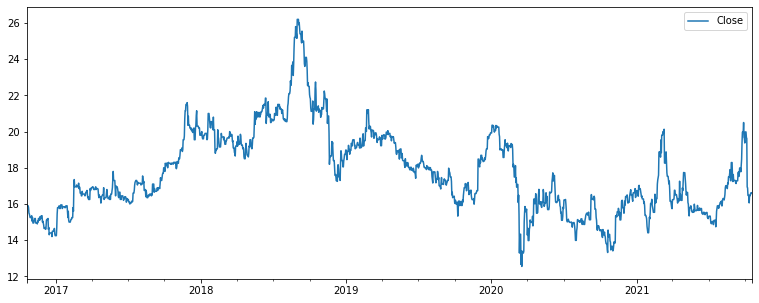

In [16]:
df_new.plot(figsize = (13,5))

In [17]:
df_mon = df_new.resample('M').mean()
df_q= df_new.resample('Q').mean()

<AxesSubplot:>

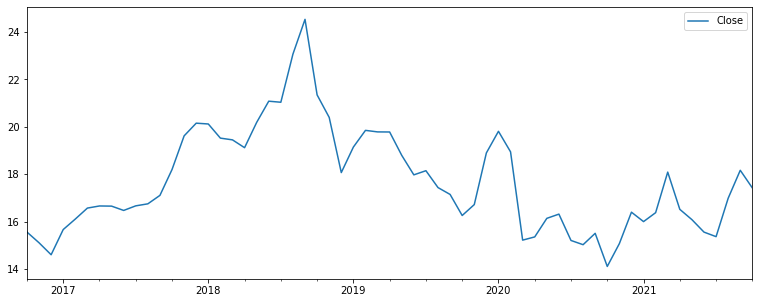

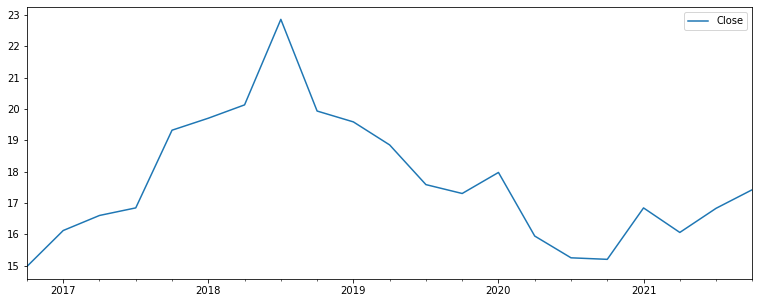

In [18]:
df_mon.plot(figsize = (13,5))
df_q.plot(figsize = (13,5))

We can also plot a month plot and a violin plot to see if there is any seasonality to the data:

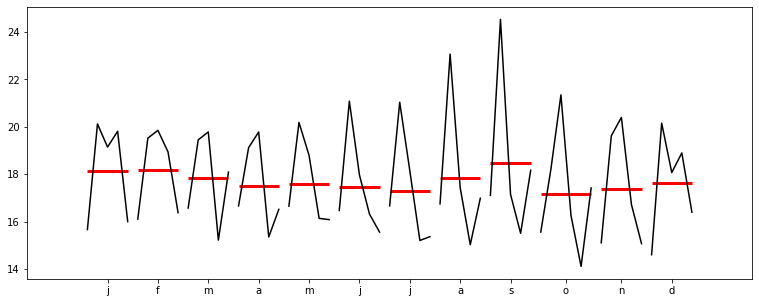

In [19]:
from statsmodels.graphics.tsaplots import month_plot

plt.rcParams['figure.figsize'] = [13, 5]
m_plot = month_plot(df_mon)

In [20]:
df_mon.head()

,Close
2016-10-31,15.562500
2016-11-30,15.110000
2016-12-31,14.605484
2017-01-31,15.667742
2017-02-28,16.110715


<AxesSubplot:ylabel='Close'>

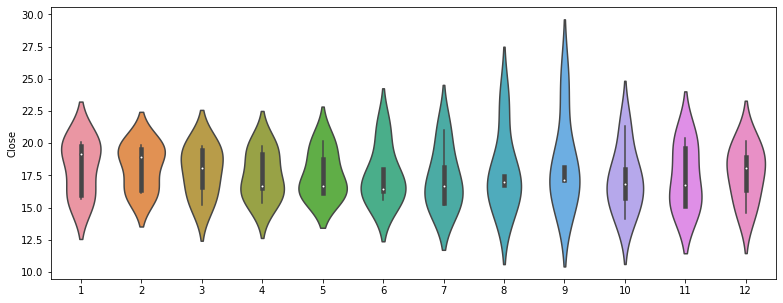

In [21]:
sns.violinplot(x=df_mon.index.month, y=df_mon.Close)

Whilst there is not any significant seasonality, the stock price appears to be slightly higher around January, February and September, with a higher variance around the summer/autumn months. 

We can look into the stationarity by plotting the rolling average and standard deviation, and by using the Dickey-Fuller Test:

In [22]:
rolmean = df_new.Close.rolling(window=100).mean()
rolstd = df_new.Close.rolling(window=100).std()

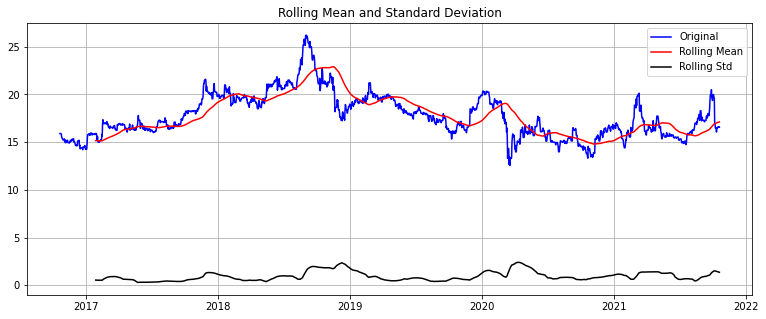

In [23]:
orig = plt.plot(df_new.Close, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation')
plt.grid()

In [24]:
import statsmodels.tsa.stattools as ts

dftest = ts.adfuller(df_new.Close)

In [25]:
pd.Series((dftest[0:2]), index=['Test Statistic','p-value'])

Test Statistic   -2.695373
p-value           0.074842
dtype: float64

In [26]:
print(dftest[4])

{'1%': -3.433940201056092, '5%': -2.8631258735235106, '10%': -2.5676142653629}


Whilst not perfect, the p-value is below 10% so we can reject the null hypothesis and state that the data is stationary. 

## Fitting the Models

### SARIMA Model

We first use a grid search method to find the best parameters for our SARIMA model (we will only train this model on the monthly average data):

In [27]:
import pmdarima as pm

stepwise_model = pm.auto_arima(df_mon.Close, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=261.429, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=180.212, Time=0.06 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=259.460, Time=0.00 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=201.608, Time=0.02 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=174.935, Time=0.14 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=249.392, Time=0.08 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=174.236, Time=0.20 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=180.031, Time=0.06 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=175.771, Time=

We then split our data into test and training samples, and train our model:

In [28]:
train_data, test_data = df_mon[0:int(len(df_mon)*0.8)], df_mon[int(len(df_mon)*0.8):]
print(train_data.shape)
print(test_data.shape)

(48, 1)
(13, 1)


In [29]:
training_data = train_data['Close'].values
testing_data = test_data['Close'].values

history = list(training_data)
model_predictions = []


for time_point in range(len(test_data)):
    model = sm.tsa.statespace.SARIMAX(history, 
                                order=(1,0,1), 
                                seasonal_order=(2,1,0,12), 
                                trend='c').fit()
    output = model.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = testing_data[time_point]
    history.append(true_test_value)

We can see how our first five predictions compare to the test data, and also calculate the Mean Squared Error: 

In [30]:
print(testing_data[0:5])
print(model_predictions[0:5])

[14.11225806 15.07466673 16.39967739 16.00258087 16.37928604]
[13.63397406375384, 14.32167280762622, 14.454071611784563, 17.873734460416703, 15.780630436497415]


In [32]:
from sklearn.metrics import mean_squared_error
MSE_error = mean_squared_error(testing_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))

Testing Mean Squared Error is 1.4480458540740244


This is a low MSE so our model has performed well.

We can then plot our predictions against our test data:

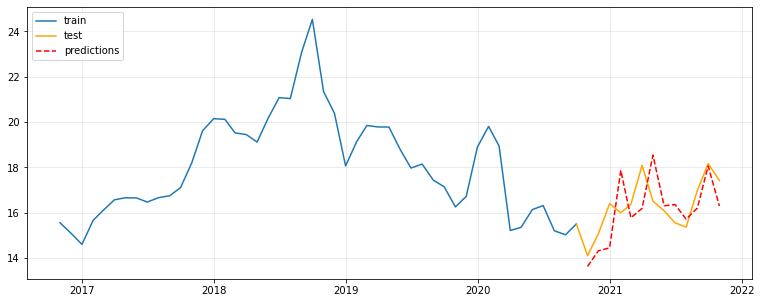

In [33]:
plt.plot(train_data, label = 'train' )
plt.plot(df_mon[47:], color = 'orange', label = 'test')
plt.plot(df_mon.index[48:], model_predictions, 'r--', label = 'predictions')
plt.legend(loc='upper left')
plt.grid(alpha=0.3);

We can also use this model to predict and plot the future stock price:

In [823]:
model = sm.tsa.statespace.SARIMAX(df_mon, 
                                  order=(1,0,1), 
                                  seasonal_order=(2,1,0,12), 
                                  trend='c').fit()

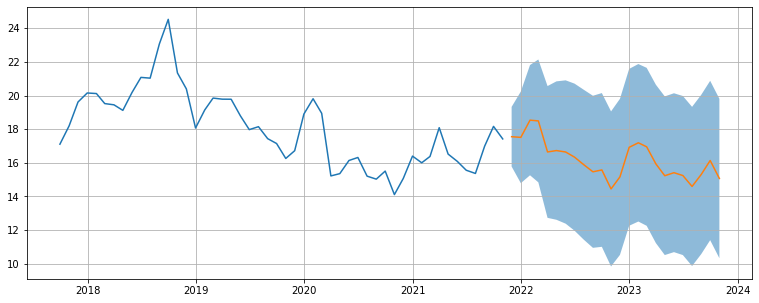

In [824]:
future_fcst = sar.get_forecast(24)
confidence_int = future_fcst.conf_int(alpha = 0.1)
fcst = future_fcst.predicted_mean

plt.plot(df_mon.Close[-50:])
plt.plot(fcst)
plt.fill_between(confidence_int.index,confidence_int['lower Close'],confidence_int['upper Close'],alpha = 0.5)
plt.grid()

### RNN Model

First we split and scale the data (we will use daily data for this model):

In [37]:
timesteps = 50

In [38]:
train = df_new[:len(df_new)-timesteps]['Close'].values
test = df_new[len(train):]['Close'].values
train=train.reshape(train.shape[0],1)
test=test.reshape(test.shape[0],1)

In [39]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range= (0,1))
train = sc.fit_transform(train)

In [40]:
train_X = []
train_y = []

for i in range(timesteps, train.shape[0]):
    train_X.append(train[i-timesteps:i,0])
    train_y.append(train[i,0])

train_X = np.array(train_X)
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
train_y = np.array(train_y)

In [41]:
print('Training input shape: {}'.format(train_X.shape))
print('Training output shape: {}'.format(train_y.shape))

Training input shape: (1726, 50, 1)
Training output shape: (1726,)


In [42]:
inputs = df_new[len(df_new) - len(test) - timesteps:]
inputs = sc.transform(inputs)

test_X = []

for i in range(timesteps, 100):
    test_X.append(inputs[i-timesteps:i,0])

test_X = np.array(test_X)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

We then build and train our RNN model:

In [45]:
model = Sequential() 

model.add(SimpleRNN(50, activation='tanh',
                    input_shape=(train_X.shape[1],1), return_sequences = True))
model.add(Dropout(0.2))
model.add(SimpleRNN(50, activation='tanh', return_sequences = True,))
model.add(Dropout(0.2))
model.add(SimpleRNN(50, activation='tanh', return_sequences = True,))
model.add(Dropout(0.2))
model.add(SimpleRNN(50, activation='tanh'))
# output layer to make final predictions 
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_X, train_y, epochs=200, batch_size=64, verbose=0)

We can then generate our predicted values and plot these against the test data:

In [46]:
test_X_init = test_X.copy()

preds1 = []

for _ in range(timesteps):
    pred = model.predict(test_X_init)
    preds1.append(pred)
    test_X_init[:,:-1,:] = test_X_init[:,1:,:]
    test_X_init[:,-1,:] = pred
    
preds1 = np.array(preds1)

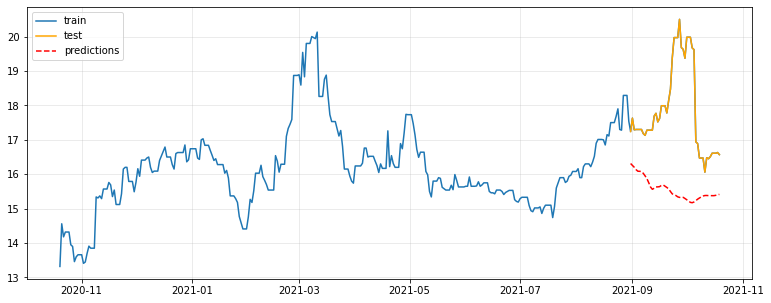

In [47]:
predicted1 = model.predict(preds1)
predicted1 = sc.inverse_transform(predicted1)

plt.plot(df_new.tail(365), label = 'train' )
plt.plot(df_new[len(df_new)-timesteps:], color = 'orange', label = 'test')
plt.plot(df_new.index[len(df_new)-timesteps:], predicted1, 'r--', label = 'predictions')
plt.legend(loc='upper left')
plt.grid(alpha=0.3);

In [49]:
MSE_error = mean_squared_error(test, predicted1)
print('Testing Mean Squared Error is {}'.format(MSE_error))

Testing Mean Squared Error is 7.270040980458457


We have a fairly low MSE score here so this model has performed well.

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 50, 50)            2600      
_________________________________________________________________
dropout (Dropout)            (None, 50, 50)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 50, 50)            5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 50, 50)            5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 50)                5

We can see that this model had to train 17,801 parameters.

### LSTM Model

We use the same train and test data from the RNN model to train our LSTM model:

In [1024]:
model2 = Sequential() 
model2.add(LSTM(70, input_shape=(train_X.shape[1],1)))
model2.add(Dense(1))

model2.compile(loss='mean_squared_error', optimizer='adam')
model2.fit(train_X, train_y, epochs=100, batch_size=64, verbose=0)

In [1025]:
test_X_init = test_X.copy()

preds2 = []

for _ in range(timesteps):
    pred = model.predict(test_X_init)
    preds2.append(pred)
    test_X_init[:,:-1,:] = test_X_init[:,1:,:] # replace first 11 values with 2nd through 12th
    test_X_init[:,-1,:] = pred
    
preds2 = np.array(preds2)

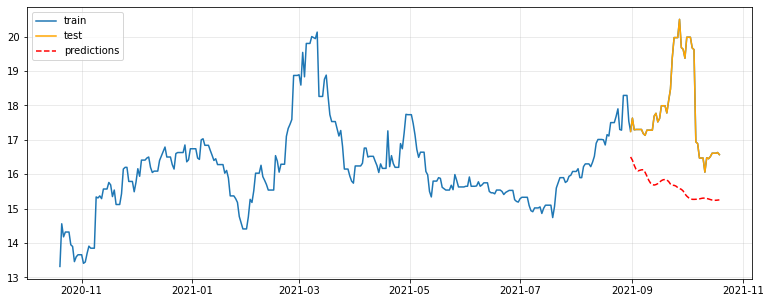

In [1026]:
predicted2 = model2.predict(preds2)
predicted2 = sc.inverse_transform(predicted2)

plt.plot(df_new.tail(365), label = 'train' )
plt.plot(df_new[len(df_new)-timesteps:], color = 'orange', label = 'test')
plt.plot(df_new.index[len(df_new)-timesteps:], predicted2, 'r--', label = 'predictions')
plt.legend(loc='upper left')
plt.grid(alpha=0.3);

In [1027]:
MSE_error = mean_squared_error(test, predicted2)
print('Testing Mean Squared Error is {}'.format(MSE_error))

Testing Mean Squared Error is 6.719510659280511


This model has a slightly lower MSE score than the RNN model so it therefore performed better. However, we can see below that it had to train more parameters. 

In [1028]:
model2.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 70)                20160     
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 71        
Total params: 20,231
Trainable params: 20,231
Non-trainable params: 0
_________________________________________________________________


We can see how the LSTM model performs when using a years worth of data to predict the next timestep:

In [1029]:
timesteps = 365

train = df_new[:len(df_new)-timesteps]['Close'].values
test = df_new[len(train):]['Close'].values
train=train.reshape(train.shape[0],1)
test=test.reshape(test.shape[0],1)

sc = MinMaxScaler(feature_range= (0,1))
train = sc.fit_transform(train)

train_X = []
train_y = []

for i in range(timesteps, train.shape[0]):
    train_X.append(train[i-timesteps:i,0])
    train_y.append(train[i,0])

train_X = np.array(train_X)
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
train_y = np.array(train_y)

inputs = df_new[len(df_new) - len(test) - timesteps:]
inputs = sc.transform(inputs)

test_X = []

for i in range(timesteps, 730):
    test_X.append(inputs[i-timesteps:i,0])

test_X = np.array(test_X)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

In [1030]:
model3 = Sequential() 
model3.add(LSTM(70, input_shape=(train_X.shape[1],1)))
model3.add(Dense(1))

model3.compile(loss='mean_squared_error', optimizer='adam')
model3.fit(train_X, train_y, epochs=200, batch_size=64, verbose = 0)

In [1031]:
test_X_init = test_X.copy()
preds3 = []

for _ in range(timesteps):
    pred = model.predict(test_X_init)
    preds3.append(pred)
    test_X_init[:,:-1,:] = test_X_init[:,1:,:] # replace first 11 values with 2nd through 12th
    test_X_init[:,-1,:] = pred
    
preds3 = np.array(preds3)

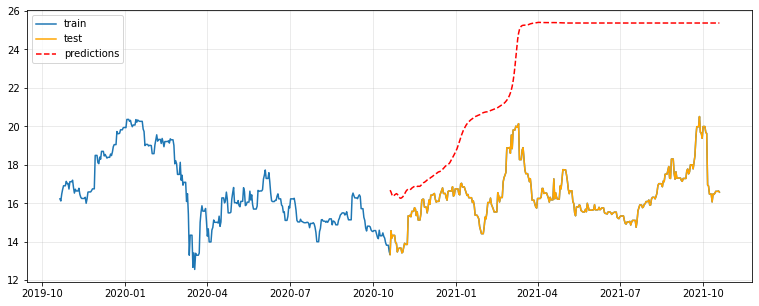

In [1032]:
predicted3 = model3.predict(preds3)
predicted3 = sc.inverse_transform(predicted3)

plt.plot(df_new.tail(730), label = 'train' )
plt.plot(df_new[len(df_new)-timesteps:], color = 'orange', label = 'test')
plt.plot(df_new.index[len(df_new)-timesteps:], predicted3, 'r--', label = 'predictions')
plt.legend(loc='upper left')
plt.grid(alpha=0.3);

In [1033]:
MSE_error = mean_squared_error(test, predicted3)
print('Testing Mean Squared Error is {}'.format(MSE_error))

Testing Mean Squared Error is 51.77946978434658


We can see that whilst this model performs well at predicting the general trend of the first few months, after this it struggles to predict the stock price accurately.  

## Analysis of Results

Given that the LSTM model had a superior MSE score to the RNN model and didn't train significantly more parameters, we can say that this is the model model for predicting Manchester United stock price data.

## Next Steps

To improve the performance of the model, we should train it over more data and run it for more epochs. 